In [1]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

# Import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

mainData

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [3]:
mainData.cellTypeName.value_counts()

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64

Check for any null values

In [4]:
mainData.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [5]:
mainData.drop(['InstanceID'], axis=1,inplace=True)
mainData.drop(['isCancerous'], axis=1,inplace=True)

In [59]:
print("#### mainData shape ####\n")
print(mainData.shape)
print("\n#### mainData info ####\n")
print(mainData.info())
print("\n#### mainData describe ####\n")
print(mainData.describe())

#### mainData shape ####

(9896, 5)

#### mainData info ####

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   patientID     9896 non-null   int64   
 1   ImageName     9896 non-null   object  
 2   cellTypeName  9896 non-null   object  
 3   cellType      9896 non-null   category
 4   Class         9896 non-null   object  
dtypes: category(1), int64(1), object(3)
memory usage: 319.2+ KB
None

#### mainData describe ####

         patientID
count  9896.000000
mean     29.762025
std      17.486553
min       1.000000
25%      14.000000
50%      26.000000
75%      47.000000
max      60.000000


Create a dictionary with label mapping for future predictions

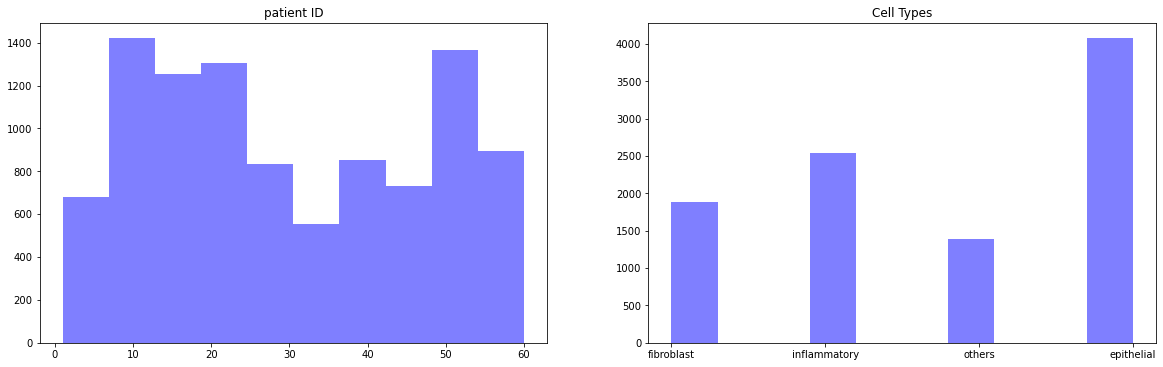

In [57]:
plt.figure(figsize=(20,20))
plt.subplot(3, 2, 1)
plt.hist(mainData['patientID'], facecolor='blue', alpha=0.5)
plt.title('patient ID')

plt.subplot(3, 2, 2)
plt.hist(mainData['cellTypeName'], facecolor='blue', alpha=0.5)
plt.title('Cell Types')
plt.show()

In [7]:
cellType_map = mainData.set_index('cellType').to_dict()['cellTypeName']

## One hot encoding won't be required as cellType seems to be already encoded

In [8]:
mainData['cellType'] = mainData['cellType'].astype('category')

In [9]:
mainData['Class'] = mainData['cellType'].astype('str')

In [10]:
# np.random.seed(43) # Consistent random list

# recCount = mainData.shape[0]
# # Each occurance of patient corresponds to an image?
# custRec = mainData.patientID.value_counts().to_dict()

# patientIds = list(custRec.keys())

# testCust = []
# testRecs = 0

# while (testRecs < (recCount * TEST_RATIO)):
#     pId = np.random.choice(patientIds)
#     ic = custRec.get(pId)
#     patientIds.remove(pId)
#     testCust.append(pId)
#     testRecs += ic 

In [11]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(mainData, test_size=0.2, random_state=42) # derterministic split
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print(train_data.shape[0], val_data.shape[0], test_data.shape[0])

5937 1979 1980


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale is done here to normalize the pixels in a range of 0-1
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# This the default batch size
batch_size = 32
x_col = "ImageName"
y_col = "Class"

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = './patch_images',
    x_col = x_col,
    y_col = y_col,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = './patch_images',
    x_col = x_col,
    y_col = y_col,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [13]:
# Learning curve diagnostic tool
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r')
    plt.plot(val_loss, 'b')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r')
    plt.plot(val_metric, 'b')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

# Baseline model

In [21]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4 # flag

base_model = keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [22]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [23]:
# base_model.compile(optimizer='SGD',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
#               metrics=['categorical_accuracy'])

base_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [24]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history1 = base_model.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

18:51:00
18:56:26
Took =  0:05:25.455315


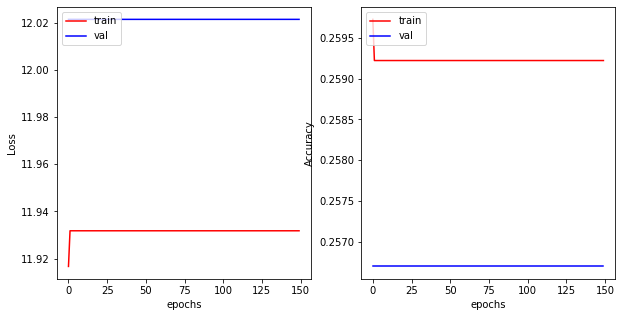

In [25]:
plot_learning_curve(history1.history['loss'], history1.history['val_loss'],
                    history1.history['categorical_accuracy'], history1.history['val_categorical_accuracy'])

Trying some regularization

In [26]:
reg_lambda = 0.01

reg_model = keras.Sequential([
    layers.Flatten(input_shape=INPUT_DIM),
    layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda)),
    layers.Dense(OUTPUT_CLASSES, kernel_regularizer=keras.regularizers.l2(reg_lambda))
])

In [27]:
reg_model.compile(optimizer='SGD',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [28]:
reg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [29]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

reg_history = reg_model.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

18:56:26
19:02:06
Took =  0:05:40.008037


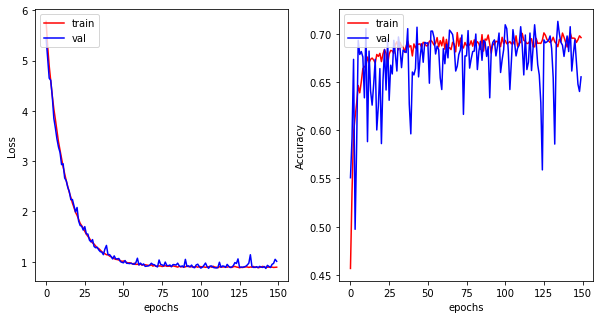

In [31]:
plot_learning_curve(reg_history.history['loss'], reg_history.history['val_loss'],
                    reg_history.history['categorical_accuracy'], reg_history.history['val_categorical_accuracy'])

## Base VGG model

In [32]:
VGG_model = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])


In [34]:
VGG_model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [36]:
VGG_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)        

In [37]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

VGG_history = VGG_model.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

19:10:15
19:37:41
Took =  0:27:25.717075


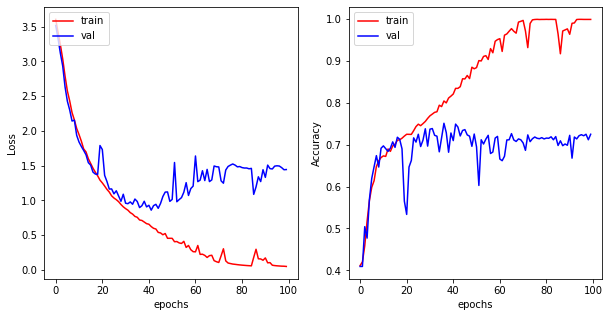

In [38]:
plot_learning_curve(VGG_history.history['loss'], VGG_history.history['val_loss'],
                    VGG_history.history['categorical_accuracy'], VGG_history.history['val_categorical_accuracy'])

 Model seems to be overfitting.

In [39]:
VGG_model2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [41]:
VGG_model2.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [43]:
VGG_model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)             

In [46]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

VGG2_history = VGG_model2.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

21:09:02
21:19:35
Took =  0:10:32.897566


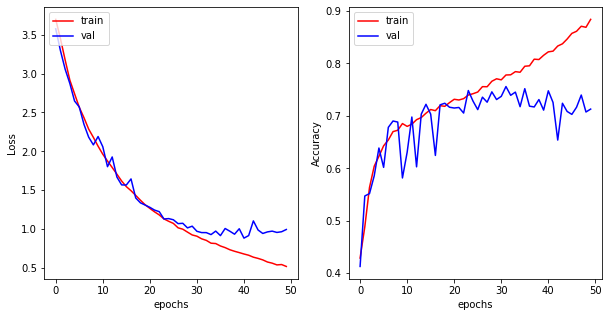

In [48]:
plot_learning_curve(VGG2_history.history['loss'], VGG2_history.history['val_loss'],
                    VGG2_history.history['categorical_accuracy'], VGG2_history.history['val_categorical_accuracy'])

Performance seems slightly better, but definately can be imporved upon. As of right now, overfitting seems to be the main problem.